In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# Ramping with I
ISIs = [0.4] * 4
ISI_pts = np.cumsum(ISIs)

# Constants
I0 = 1.5
beta = 1.5
alpha = 5

# Initialize
IS = I0
IP = I0
y0 = 0.7

# For storage
yS_lst = []
IS_lst = []
IP_lst = []
productions = []

# Synchronization
for i in range(len(ISIs)):
    print(i, ISI_pts[i-1])
    # Period adjustment
    yS = IS * ISIs[i]
    IS_new = IS - beta * (yS - y0)
    print('yS = ', yS, 'IS = ', IS)
    yS_lst.append(yS)
    IS_lst.append(IS_new)
    
    # Make production
    tp = y0 / IP
    productions.append(tp)
    print('tp =  ', tp)
    
    # Phase adjustments
    if i == 0:
        IP = IS_new + alpha * (np.sum(productions) - (y0 / IS))
    else:
        print('*** Production total: ', np.sum(productions))
        print('*** ISI total: ', ISI_pts[i - 1] + y0/IS)
        IP = IS_new + alpha * (np.sum(productions) - (ISI_pts[i - 1] + y0 / IS))
    IS = IS_new
    IP_lst.append(IP)
    print('IP = ', IP)
    
    
# Continuation
n_continuation = 5
continuation_const = 0.1
for i in range(n_continuation):
    # Period adjustment: IS unchanged since no stimulus is observed
    IS_new = IS
    
    # Make production
    tp = y0 / IP
    productions.append(tp)
    print('tp =  ', tp)
    
    # Phase adjustments
    IP = IS_new + alpha * (continuation_const)
    IS = IS_new
    IP_lst.append(IP)
    print('IP = ', IP)
    

    








0 1.6
yS =  0.6000000000000001 IS =  1.5
tp =   0.4666666666666666
IP =  1.65
1 0.4
yS =  0.66 IS =  1.65
tp =   0.42424242424242425
*** Production total:  0.8909090909090909
*** ISI total:  0.8242424242424242
IP =  2.043333333333333
2 0.8
yS =  0.6839999999999999 IS =  1.7099999999999997
tp =   0.3425774877650898
*** Production total:  1.2334865786741807
*** ISI total:  1.209356725146199
IP =  1.8546492676399082
3 1.2000000000000002
yS =  0.6936 IS =  1.7339999999999998
tp =   0.3774298527563484
*** Production total:  1.610916431430529
*** ISI total:  1.603690888119954
IP =  1.7797277165528749
tp =   0.3933185922146666
IP =  2.2436
tp =   0.31199857372080586
IP =  2.2436
tp =   0.31199857372080586
IP =  2.2436
tp =   0.31199857372080586
IP =  2.2436
tp =   0.31199857372080586
IP =  2.2436


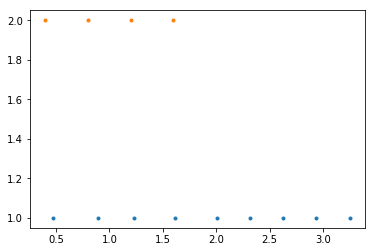

In [82]:
# Plot the result
plt.plot(np.cumsum(productions), np.ones(len(productions)), '.')
plt.plot(ISI_pts, np.ones(len(ISI_pts)) * 2, '.')

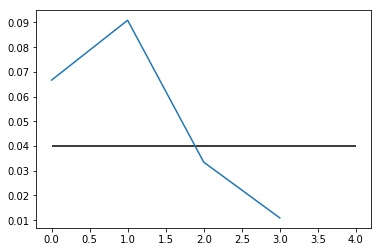

In [68]:
plt.plot(np.cumsum(productions) - ISI_pts)
plt.hlines(0.04, 0, len(ISI_pts))

In [5]:
ISI_pts

array([ 400,  800, 1200, 1600], dtype=int32)

In [44]:
plt.hlines?

## Discrete updating algorithm

### Continuous time definitions
$y_{\textrm{ref}}$ : Reference level

$y_{\textrm{SAM}}$ : Output of SAM

$y_{\textrm{MPM}}$ : Output of of MPM

$I_{\textrm{SAM}}$ : Input to SAM

$I_{\textrm{MPM}}$ : Input to MPM


### Translation into discrete time
$i$ will index *time-points* and *intervals*

$t_p^i$ : time of $i$th production

$t_s^i$ : time of $i$th stimulus

$\textrm{ISI}^i$ = $t_s^{i+1} - t_s^i$

$\textrm{IPI}^i$ = $t_p^{i+1} - t_p^i$

$y_{\textrm{SAM}}^i=I_{\textrm{SAM}}^i*\textrm{ISI}^i$

$I_{\textrm{SAM}}^{i+1}=I_{\textrm{SAM}}^i+\beta(y_{\textrm{ref}}-y_{\textrm{SAM}}^i)$

$I_{\textrm{MPM}}^{i+1} = I_{\textrm{SAM}}^{i+1} + \alpha(y_{\textrm{out}}^i-y_{\textrm{MPM}}^i)$

$\textrm{IPI}^i=y_{\textrm{ref}}/I_{\textrm{MPM}}$

$t_p^{i+1}=t_p^i+\textrm{IPI}^i$

By definition $y_{\textrm{MPM}}^i=y_{\textrm{ref}}$ (output of $y_{\textrm{MPM}}$ at ith production)

The value of $y_{\textrm{out}}^i$ represents the output of the SAM at the time of the $i$th production. During synchronization that will be:

if $t_s^{i}<t_p^i$

$y_{\textrm{out}}^i = I_{\textrm{SAM}}^i*(t_p^{i}-t_s^{i})$

else

$y_{\textrm{out}}^i = I_{\textrm{SAM}}^i*(t_p^i-t_s^{i-1})$


During continuation:

$y_{\textrm{out}}^i = y_{\textrm{SAM}}^\infty$

with $y_{\textrm{SAM}}^\infty$ representing the terminal output of the SAM module.

In [4]:
# Definitions
def I_s_update(I_s_in,beta,y_ref,y_s):
    I_s_out = I_s_in + beta*(y_ref - y_s)
    
    return I_s_out

def I_p_update(I_s,alpha,y_p,y_out):
    I_p_out = I_s + alpha*(y_out-y_p)
    
    return I_p_out

def discreteAlgorithm(ISI, beta=0.5, alpha=0.1, y_ref=1, I_s_init=0.8, y_s_infty=1.5):

    t_s = np.zeros(len(ISI)+1)
    t_s[1:len(ISI)+1] = np.cumsum(ISI)
    IPI = np.zeros((len(t_s)))
    t_p = np.zeros((len(t_s)))
    I_s = np.zeros((len(t_s)))
    I_p = np.zeros((len(t_s)))
    y_s = np.zeros((len(t_s)))
    I_p[0] = I_s_init
    I_s[0] = I_s_init

    for i in range(len(ISI)):

        IPI[i] = y_ref/I_p[i]
        if i > 0:
            t_p[i+1] = t_p[i] + IPI[i]
        else:
            t_p[i+1] = IPI[i]
        
        if np.isnan(ISI[i]):
            y_s[i] = y_s_infty
            I_s[i+1] = I_s[i]
        else:
            y_s[i] = I_s[i]*ISI[i]
            I_s[i+1] = I_s_update(I_s[i],beta,y_ref,y_s[i])

        
        if np.isnan(ISI[i]):
            y_out = y_s_infty
        else:
            if t_s[i] < t_p[i]:
                y_out = I_s[i]*(t_p[i]-t_s[i])
            else:
                if i == 0:
                    y_out = y_ref
                else:
                    y_out = I_s[i]*(t_p[i]-t_s[i-1])
                #print(i,y_out)


        I_p[i+1] = I_p_update(I_s[i+1],alpha,y_ref,y_out)
        
        #print(t_s[i],t_p[i],IPI[i])
    
    return t_s, t_p, IPI, I_s, I_p, y_s

## Synchronization to a constant ISI

In [6]:
# Simple synchronization
ISI = [0.4] * 500
t_s, t_p, IPI, I_s, I_p, y_s = discreteAlgorithm(ISI, beta=0.2, alpha=0.1, y_ref=1, I_s_init=1/0.35)

#for i in range(len(t_s)):
#    print(t_s[i],t_p[i],IPI[i])

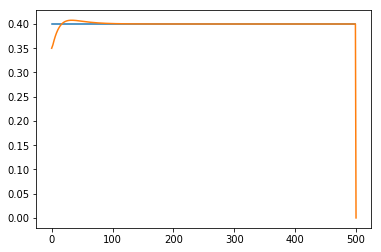

In [7]:
plt.plot(ISI)
plt.plot(IPI)

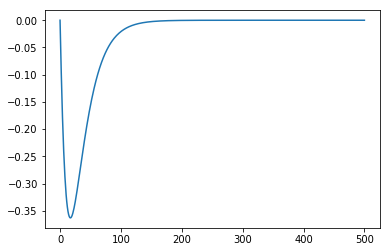

In [8]:
plt.plot(t_p-t_s)

## Step Change

In [9]:
# Step change
ISI = np.concatenate((0.80*np.ones(100),1.00*np.ones(30)))
del t_p
del t_s
del IPI
del I_s
del I_p
del y_s
t_s, t_p, IPI, I_s, I_p, y_s = discreteAlgorithm(ISI, beta=0.5, alpha=0.1, y_ref=1, I_s_init=1/0.8)

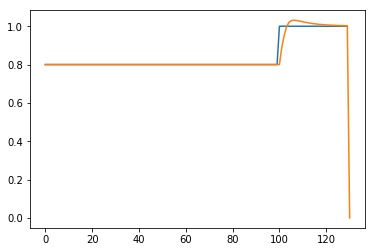

In [10]:
plt.plot(ISI)
plt.plot(IPI)

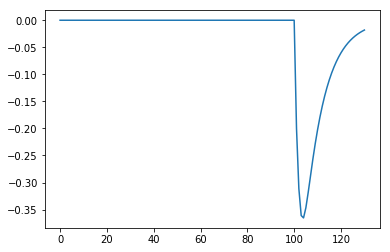

In [11]:
plt.plot(t_p-t_s)

## Phase shift

In [51]:
# Phase shift
ISI = np.concatenate((0.80*np.ones(50),0.75*np.ones(1),0.80*np.ones(50)))
del t_p
del t_s
del IPI
del I_s
del I_p
del y_s
t_s, t_p, IPI, I_s, I_p, y_s = discreteAlgorithm(ISI, beta=0.0, alpha=0.1, y_ref=1, I_s_init=1/0.8)

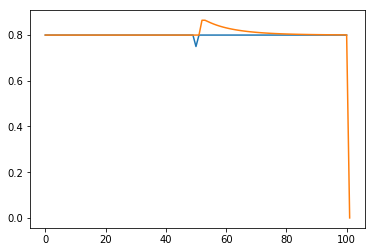

In [52]:
plt.plot(ISI)
plt.plot(IPI)

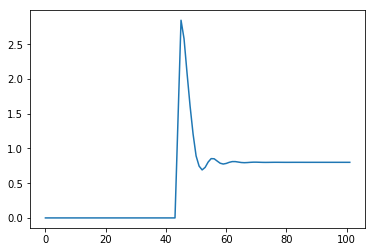

In [50]:
plt.plot(t_p-t_s)

## Stimulus jitter

## 1-2-Go, 1-2-3-Go

## Synchronization/continuation

In [17]:
# Step change
ISI = np.concatenate((0.80*np.ones(4),np.nan*np.ones(8)))
del t_p
del t_s
del IPI
del I_s
del I_p
del y_s
t_s, t_p, IPI, I_s, I_p, y_s = discreteAlgorithm(ISI, beta=0.75, alpha=0.0, y_ref=1, I_s_init=1/0.6)

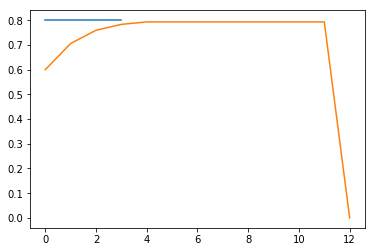

In [18]:
plt.plot(ISI)
plt.plot(IPI)

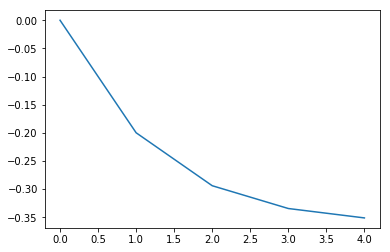

In [19]:
plt.plot(t_p-t_s)